# Classless Analyitical Model

## Description

This is a classless modeling proposal of the webapp workflow case study proposed in the following book:
>  Performance Engineering Learning Through Applications Using JMT - Giuseppe Serazzi, chapter 6.3

In this proposal all jobs are serviced according to the following rules:
- Server B services all incoming jobs with class 1 service rate;
- Server P treats all incoming jobs with class 2 service rate;
- Server A treats all incoming jobs with a service rate averaged equally among classes.

## Queue Network Model

![basic queue network](../figs/webapp_conceptual.drawio.png)

In [ ]:
import csv
import os
from sympy import Idx, IndexedBase, Symbol
import sympy
from tabulate import tabulate
from IPython.display import display, Math, Latex

print(f"using sympy {sympy.__version__}")

sep_line="----------------------------------"

servers = ["A", "B", "P"]
classes = ["1", "2", "3"]
GLOBAL = "global"

s = Idx("s")
"""
server index
"""
c = Idx("c")
"""
class index
"""
mu = IndexedBase("mu", shape=(len(servers), len(classes)))
"""
service rate of server s for jobs of class c
"""
p = IndexedBase("p", shape=(len(servers), len(classes)))
"""
probability that a job in service at server s is of class c
"""
gamma = Symbol("gamma")
"""
external mean arrival rate
"""
x = IndexedBase("X", shape=(len(servers)))
"""
throughput of server s
"""
e_t = IndexedBase("E[T]", shape=(len(servers)))
"""
expected response time (at server s, or global if omitted)
"""
e_n = IndexedBase("E[N]", shape=(len(servers)))
"""
expected job population (at server s, or global if omitted)
"""
v = IndexedBase("v", shape=(len(servers)))
"""
mean number of visits of a job to server s
"""
mu_s = IndexedBase("mu", shape=(len(servers)))
"""
mean service rate of server s without considering the job class
"""
lambda_ = IndexedBase("lambda", shape=(len(servers)))
"""
mean arrival rate at server s
"""
rho = IndexedBase("rho", shape=(len(servers)))
"""
utilization of server s
"""

service_rates_vanilla = {
    "A": {
        "1": 1 / 0.2,
        "2": 1 / 0.4,
        "3": 1 / 0.1,
    },
    "B" : {
        "1": 1 / 0.8,
        "2": 0.0,
        "3": 0.0,
    },
    "P": {
        "1": 0.0,
        "2": 1 / 0.4,
        "3": 0.0,
    }
}

service_rates_2fa = {
    "A": {
        "1": 1 / 0.2,
        "2": 1 / 0.4,
        "3": 1 / 0.15,
    },
    "B" : {
        "1": 1 / 0.8,
        "2": 0.0,
        "3": 0.0,
    },
    "P": {
        "1": 0.0,
        "2": 1 / 0.7,
        "3": 0.0,
    }
}

service_rates_B_improved = {
    "A": {
        "1": 1 / 0.2,
        "2": 1 / 0.4,
        "3": 1 / 0.1,
    },
    "B" : {
        "1": 1 / 0.4,
        "2": 0.0,
        "3": 0.0,
    },
    "P": {
        "1": 0.0,
        "2": 1 / 0.4,
        "3": 0.0,
    }
}
def dump_data_as_csv(data, filename):

    with open(filename, "w") as f:
        writer = csv.writer(f)
        writer.writerows(data)

external_arrival_rates_light = [rate / 100.0 for rate in range(50, 125, 5)]
external_arrival_rates_heavy = [rate / 100.0 for rate in range(50, 145, 5)]

sympy.init_printing()

display(f"servers={servers}", f"classes={classes}")
display("light arrival rates", external_arrival_rates_light)
display("heavy arrival rates", external_arrival_rates_heavy)
display("service rates vanilla", service_rates_vanilla)
display("service_rates_2fa", service_rates_2fa)

## Assumptions:

1) Server A treats all incoming jobs with a service rate averaged equally among classes.

We compute the service rate of server A assuming that all jobs are serviced with such rate, regardless of their class. Besides, we use an uniform distribution of job class probability.

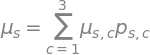

'----------------------------------'

In [29]:
from sympy import Eq, Sum, Symbol, Rational

service_rates = service_rates_vanilla

# probability that a job of class c is in service at server s,
# given that a job is in service at server s
class_probabilities = {
    "A": {
        "1": Rational(1, 3),
        "2": Rational(1, 3),
        "3": Rational(1, 3),
    },
    "B": {
        "1": 1,
        "2": 0,
        "3": 0,
    },
    "P": {
        "1": 0,
        "2": 1,
        "3": 0,
    }
}

def get_mu_expr():
    return Sum(mu[s, c] * p[s, c], (c, classes[0], classes[-1]))

def get_mu_s_expr(index_s):
    mu_s_expr = Sum(mu[s, c] * p[s, c], (s, index_s, index_s), (c, 0, len(classes) - 1))
    return mu_s_expr

def calc_mu_s(server, class_probabilities, service_rates):
    
    index_s = server
    mu_s_expr = get_mu_s_expr(index_s)

    mu_s_expr = mu_s_expr.doit()
    mu_s_values = {}
    for cl in classes:
        index_c = classes.index(cl)
        mu_s_values.update({
            p[index_s, index_c]: class_probabilities[cl],
            mu[index_s, index_c]: service_rates[server][cl]
        })

    mu_s_res = mu_s_expr.subs(mu_s_values, simultaneous=True)
    display(Eq(mu_s[index_s], mu_s_res))
    return mu_s_res

def calc_mu_vals():

    display(Eq(mu_s[s], get_mu_expr()))
    display(sep_line)

    mu_a_val = calc_mu_s("A", class_probabilities["A"], service_rates)

    # we can use same code to calc mu of other servers

    mu_b_val = calc_mu_s("B", class_probabilities["B"], service_rates)
    mu_p_val = calc_mu_s("P", class_probabilities["P"], service_rates)

    mu_vals = {
        "A": mu_a_val,
        "B": mu_b_val,
        "P": mu_p_val
    }

    return mu_vals

mu_vals = calc_mu_vals()

2) Job flow is balanced. Namely, no job is created/destroyed inside the system.

Using the above assumptions we can compute local arrival rates at each node of the network

In [ ]:
from sympy import Eq, Expr, IndexedBase, solve

def display_lambda_eqs():

    lambda_a = Eq(lambda_["A"], gamma + x["B"] + x["P"])
    lambda_b = Eq(lambda_["B"], x["B"])
    lambda_p = Eq(lambda_["P"], x["P"])

    lambdas = {
        "A": lambda_a,
        "B": lambda_b,
        "P": lambda_p,
    }

    for server in servers:
        display(lambdas[server])

display_lambda_eqs()

def solve_flow_balance_eqs():

    # solve flow balance linear system of equations
    flow_balance_a = Eq(gamma + x["B"] + x["P"], Sum(x[s] * p[s, c], (s, "A", "A"), (c, "1", "3")).doit())
    display("flow balance for A:", flow_balance_a)
    flow_balance_b = Eq(x["A"] * p["A","1"], x["B"])
    display("flow balance for B:", flow_balance_b)
    flow_balance_p = Eq(x["A"] * p["P", "2"], x["P"])
    display("flow balance for P:", flow_balance_p)

    flow_balance_eqs = [
        flow_balance_a,
        flow_balance_b,
        flow_balance_p,
    ]

    for i in range(len(flow_balance_eqs)):
        for cl in classes:
            for server in servers:
                index_c = classes.index(cl)
                flow_balance_eqs[i] = flow_balance_eqs[i].doit().subs(p[server, cl], class_probabilities["A"][cl])

    display("flow balance system:", flow_balance_eqs)

    throughputs = solve(flow_balance_eqs, x["A"], x["B"], x["P"])
    display("using class probabilities:", class_probabilities)
    display("solve for throughputs", throughputs)

    lambda_exprs = {
        "A": gamma + throughputs[x["B"]] + throughputs[x["P"]],
        "B": throughputs[x["B"]],
        "P": throughputs[x["P"]],
    }

    display(sep_line)
    for server in servers:
        display(Eq(lambda_[server], lambda_exprs[server]))
    
    return lambda_exprs, throughputs

lambda_exprs, throughputs = solve_flow_balance_eqs()


## Objective 1

We check for system stability for each arrival rate used in the experiment

In [ ]:
external_arrival_rates = external_arrival_rates_light

def is_stable(rho_values):
    for value in rho_values:
        if value >= 1:
            return False
    return True

def display_rho_eq():
    mu_s = Symbol(f"mu_s")
    display(Eq(rho[s], lambda_[s] / mu_s))

display_rho_eq()

display("Searching for stable system configurations ...")

def calc_rho_vals(objective):

    rho_values = {}
    stable_rates = []

    data = []
    data.append([gamma, *[rho[s] for s in servers], "stable"])
    for rate in external_arrival_rates:

        rho_values_per_server = {}
        stable = False
        
        for server in servers:

            index_s = server

            mu_s_expr = get_mu_s_expr(index_s)
            mu_s_expr = mu_s_expr.doit().subs({p[index_s, classes.index(cl)]: class_probabilities[server][cl] for cl in classes}, simultaneous=True)
            mu_s_expr = mu_s_expr.subs({mu[index_s, classes.index(cl)]: service_rates[server][cl] for cl in classes}, simultaneous=True)
            rho_expr = lambda_[index_s] / mu_s_expr
            rho_expr = rho_expr.subs(lambda_[index_s], lambda_exprs[server])
            rho_expr = rho_expr.subs(gamma, rate)

            rho_values_per_server[server] = rho_expr
            
        if is_stable(rho_values_per_server.values()):
            stable_rates.append(rate)
            rho_values[rate] = rho_values_per_server
            stable = True
            
        data.append([rate, *[rho_values_per_server[s] for s in servers], stable])

    table = tabulate(data, headers="firstrow", tablefmt="html")
    display(table)
    dump_data_as_csv(data, os.path.join('..', 'plots', 'output', f"{objective}_analitycal_rho.csv"))

    return rho_values, stable_rates

rho_values, stable_rates = calc_rho_vals("obj1")

### Local performances
We assume a Processor Sharing (PS) queue policy for each server, since this is the policy used in the case study.

Throughputs have already been computed when solving the queue network

N is computed using Little's Law.

In [ ]:
def calc_local_performances(objective):

    e_t_values = {}
    e_n_values = {}
    x_values = {}

    for rate in stable_rates:
        e_t_values[rate] = {}
        e_n_values[rate] = {}
        x_values[rate] = {}

    e_t_expr = 1 / (mu_s[s] * (1 - rho[s]))
    display(Eq(e_t[s], e_t_expr))

    e_n_expr = lambda_[s] * e_t[s]
    display(Eq(e_n[s], e_n_expr))

    display(throughputs)

    data = []
    data.append([gamma, *[e_t[s] for s in servers], *[e_n[s] for s in servers], *[x[s] for s in servers]])
    for rate in rho_values.keys():
        for server in servers:
            
            # response time
            mu_s_expr = get_mu_s_expr(server).doit().subs({mu[server, cl]: service_rates[server][cl] for cl in classes}, simultaneous=True)
            mu_s_val = mu_vals[server]
            rho_val = rho_values[rate][server]
            e_t_val = e_t_expr.subs({
                mu_s[s]: mu_s_val,
                rho[s]: rho_val
            }).doit()
            e_t_values[rate][server] = e_t_val

            # throughput
            x_val = throughputs[x[server]].subs(gamma, rate)
            x_values[rate][server] = x_val

            # mean population
            lambda_expr = lambda_exprs[server].subs(gamma, rate)
            e_n_val = e_n_expr.subs({
                lambda_[s]: lambda_expr,
                e_t[s]: e_t_val
            })
            e_n_values[rate][server] = e_n_val

        
        data.append([rate, *[e_t_values[rate][s] for s in servers], *[e_n_values[rate][s] for s in servers], *[x_values[rate][s] for s in servers]])

    table = tabulate(data, headers="firstrow", tablefmt="html")
    display(table)

    dump_data_as_csv(data, os.path.join('..', 'plots', 'output', f"{objective}_analitycal_local_performances.csv"))

    return e_t_values, e_n_values, x_values

e_t_values, e_n_values, x_values = calc_local_performances("obj1")


### Global Performances

We have to consider mean job visits to each node in order to compute the global mean response time.

Global throughput is given by external arrival rate $\gamma$ in each stable configuration.

Once again, we can leverage little to compute the global mean population.

In [ ]:
def evaluate_e_t_global(expr, rate, v_values):
    expr_e_t_global_evaluated = expr
    for server in servers:
        index_s = servers.index(server)
        expr_e_t_global_evaluated = expr_e_t_global_evaluated.subs({
            v[index_s]: v_values[server],
            e_t[index_s]: e_t_values[rate][server],
        })
    return expr_e_t_global_evaluated

def calc_v_values():
    v_expr = lambda_[s] / gamma
    display(Eq(v[s], v_expr))
    display(sep_line)
    v_values = {}
    for server in servers:
        v_values[server] = v_expr.subs({ lambda_[s]: lambda_exprs[server] })
        display(Eq(v[server], v_values[server]))
    return v_values

def calc_global_performances(objective):

    display(Eq(e_t, Sum(v[s] * e_t[s], (s, servers[0], servers[-1]))))
    display(Eq(e_n, gamma * e_t))
    x_expr = x["A"] * p["A", "3"]
    display(Eq(x, x_expr))
    
    e_t_global_values = {}
    e_n_global_values = {}
    x_global_values = {}

    data = []
    data.append([gamma, e_t['S'], e_n['S'], x['S']]) 
    for rate in stable_rates:
        
        # Response time
        e_t_global_expr = Sum(v[s] * e_t[s], (s, 0, len(servers) - 1)).doit()
        e_t_global_value = evaluate_e_t_global(e_t_global_expr, rate, v_values)
        e_t_global_values[rate] = e_t_global_value

        # Population
        e_n_global_expr = gamma * e_t_global_expr
        e_n_global_expr = evaluate_e_t_global(e_n_global_expr, rate, v_values)
        e_n_global_val = e_n_global_expr.subs(gamma, rate)
        e_n_global_values[rate] = e_n_global_val

        # Throughput
        x_global_val = x_expr.subs({
            x["A"]: throughputs[x["A"]],
            gamma: rate,
            p["A", "3"]: class_probabilities["A"]["3"]
        })
        x_global_values[rate] = x_global_val

        data.append([rate, e_t_global_value, e_n_global_val, x_global_val])

    table = tabulate(data, headers="firstrow", tablefmt="html")
    display(table)
    dump_data_as_csv(data, os.path.join('..', 'plots', 'output', f"{objective}_analitycal_global_performances.csv"))

    return e_t_global_values, e_n_global_values, x_global_values

v_values = calc_v_values()
display(sep_line)
e_t_global_values, e_n_global_values, x_global_values = calc_global_performances("obj1")
        

## Objective 2

Introducing a 2FA system deployed in Server A and B changes the average Service time respectively for jobs of class 3 and 2.

In [ ]:
service_rates = service_rates_2fa
obj = "obj2"

mu_vals = calc_mu_vals()
display(sep_line)
rho_values, stable_rates = calc_rho_vals(obj)
display(sep_line)
e_t_values, e_n_values, x_values = calc_local_performances(obj)
display(sep_line)
e_t_global_values, e_n_global_values, x_global_values = calc_global_performances(obj)


## Objective 3

We increase the arrival rates to further stress the system

In [ ]:
service_rates = service_rates_vanilla
external_arrival_rates = external_arrival_rates_heavy

obj = "obj3"

mu_vals = calc_mu_vals()
display(sep_line)
rho_values, stable_rates = calc_rho_vals(obj)
display(sep_line)
e_t_values, e_n_values, x_values = calc_local_performances(obj)
display(sep_line)
e_t_global_values, e_n_global_values, x_global_values = calc_global_performances(obj)


## Objective 4 (Improvement)

By looking at $\rho$ values we observe that server B seems to be overwhelmed when the external arrival rate is $\gamma > 1.2 $ req/s, so we replace it with a new performant one, as the case study reports.

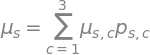

'----------------------------------'

'----------------------------------'

gamma,rho[A],rho[B],rho[P],stable
0.5,0.257143,0.35,0.2,True
0.55,0.282857,0.385,0.22,True
0.6,0.308571,0.42,0.24,True
0.65,0.334286,0.455,0.26,True
0.7,0.36,0.49,0.28,True
0.75,0.385714,0.525,0.3,True
0.8,0.411429,0.56,0.32,True
0.85,0.437143,0.595,0.34,True
0.9,0.462857,0.63,0.36,True
0.95,0.488571,0.665,0.38,True


'----------------------------------'

gamma,E[T][A],E[T][B],E[T][P],E[N][A],E[N][B],E[N][P],X[A],X[B],X[P]
0.5,0.230769,1.07692,0.5,0.346154,0.538462,0.25,1.5,0.5,0.5
0.55,0.239044,1.13821,0.512821,0.394422,0.626016,0.282051,1.65,0.55,0.55
0.6,0.247934,1.2069,0.526316,0.446281,0.724138,0.315789,1.8,0.6,0.6
0.65,0.257511,1.2844,0.540541,0.502146,0.834862,0.351351,1.95,0.65,0.65
0.7,0.267857,1.37255,0.555556,0.5625,0.960784,0.388889,2.1,0.7,0.7
0.75,0.27907,1.47368,0.571429,0.627907,1.10526,0.428571,2.25,0.75,0.75
0.8,0.291262,1.59091,0.588235,0.699029,1.27273,0.470588,2.4,0.8,0.8
0.85,0.304569,1.7284,0.606061,0.77665,1.46914,0.515152,2.55,0.85,0.85
0.9,0.319149,1.89189,0.625,0.861702,1.7027,0.5625,2.7,0.9,0.9
0.95,0.335196,2.08955,0.645161,0.955307,1.98507,0.612903,2.85,0.95,0.95


'----------------------------------'

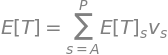

gamma,E[T][S],E[N][S],X[S]
0.5,2.26923,1.13462,0.5
0.55,2.36816,1.30249,0.55
0.6,2.47701,1.48621,0.6
0.65,2.59748,1.68836,0.65
0.7,2.73168,1.91217,0.7
0.75,2.88232,2.16174,0.75
0.8,3.05293,2.44234,0.8
0.85,3.24816,2.76094,0.85
0.9,3.47434,3.1269,0.9
0.95,3.7403,3.55329,0.95


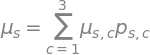

'----------------------------------'

'----------------------------------'

gamma,rho[A],rho[B],rho[P],stable
0.5,0.257143,0.3,0.2,True
0.55,0.282857,0.33,0.22,True
0.6,0.308571,0.36,0.24,True
0.65,0.334286,0.39,0.26,True
0.7,0.36,0.42,0.28,True
0.75,0.385714,0.45,0.3,True
0.8,0.411429,0.48,0.32,True
0.85,0.437143,0.51,0.34,True
0.9,0.462857,0.54,0.36,True
0.95,0.488571,0.57,0.38,True


'----------------------------------'

gamma,E[T][A],E[T][B],E[T][P],E[N][A],E[N][B],E[N][P],X[A],X[B],X[P]
0.5,0.230769,0.857143,0.5,0.346154,0.428571,0.25,1.5,0.5,0.5
0.55,0.239044,0.895522,0.512821,0.394422,0.492537,0.282051,1.65,0.55,0.55
0.6,0.247934,0.9375,0.526316,0.446281,0.5625,0.315789,1.8,0.6,0.6
0.65,0.257511,0.983607,0.540541,0.502146,0.639344,0.351351,1.95,0.65,0.65
0.7,0.267857,1.03448,0.555556,0.5625,0.724138,0.388889,2.1,0.7,0.7
0.75,0.27907,1.09091,0.571429,0.627907,0.818182,0.428571,2.25,0.75,0.75
0.8,0.291262,1.15385,0.588235,0.699029,0.923077,0.470588,2.4,0.8,0.8
0.85,0.304569,1.22449,0.606061,0.77665,1.04082,0.515152,2.55,0.85,0.85
0.9,0.319149,1.30435,0.625,0.861702,1.17391,0.5625,2.7,0.9,0.9
0.95,0.335196,1.39535,0.645161,0.955307,1.32558,0.612903,2.85,0.95,0.95


'----------------------------------'

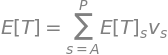

gamma,E[T][S],E[N][S],X[S]
0.5,2.04945,1.02473,0.5
0.55,2.12547,1.16901,0.55
0.6,2.20762,1.32457,0.6
0.65,2.29668,1.49284,0.65
0.7,2.39361,1.67553,0.7
0.75,2.49955,1.87466,0.75
0.8,2.61587,2.09269,0.8
0.85,2.74426,2.33262,0.85
0.9,2.88679,2.59812,0.9
0.95,3.0461,2.89379,0.95


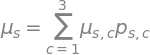

'----------------------------------'

'----------------------------------'

gamma,rho[A],rho[B],rho[P],stable
0.5,0.257143,0.25,0.2,True
0.55,0.282857,0.275,0.22,True
0.6,0.308571,0.3,0.24,True
0.65,0.334286,0.325,0.26,True
0.7,0.36,0.35,0.28,True
0.75,0.385714,0.375,0.3,True
0.8,0.411429,0.4,0.32,True
0.85,0.437143,0.425,0.34,True
0.9,0.462857,0.45,0.36,True
0.95,0.488571,0.475,0.38,True


'----------------------------------'

gamma,E[T][A],E[T][B],E[T][P],E[N][A],E[N][B],E[N][P],X[A],X[B],X[P]
0.5,0.230769,0.666667,0.5,0.346154,0.333333,0.25,1.5,0.5,0.5
0.55,0.239044,0.689655,0.512821,0.394422,0.37931,0.282051,1.65,0.55,0.55
0.6,0.247934,0.714286,0.526316,0.446281,0.428571,0.315789,1.8,0.6,0.6
0.65,0.257511,0.740741,0.540541,0.502146,0.481481,0.351351,1.95,0.65,0.65
0.7,0.267857,0.769231,0.555556,0.5625,0.538462,0.388889,2.1,0.7,0.7
0.75,0.27907,0.8,0.571429,0.627907,0.6,0.428571,2.25,0.75,0.75
0.8,0.291262,0.833333,0.588235,0.699029,0.666667,0.470588,2.4,0.8,0.8
0.85,0.304569,0.869565,0.606061,0.77665,0.73913,0.515152,2.55,0.85,0.85
0.9,0.319149,0.909091,0.625,0.861702,0.818182,0.5625,2.7,0.9,0.9
0.95,0.335196,0.952381,0.645161,0.955307,0.904762,0.612903,2.85,0.95,0.95


'----------------------------------'

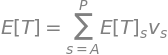

gamma,E[T][S],E[N][S],X[S]
0.5,1.85897,0.929487,0.5
0.55,1.91961,1.05578,0.55
0.6,1.9844,1.19064,0.6
0.65,2.05381,1.33498,0.65
0.7,2.12836,1.48985,0.7
0.75,2.20864,1.65648,0.75
0.8,2.29536,1.83628,0.8
0.85,2.38933,2.03093,0.85
0.9,2.49154,2.24238,0.9
0.95,2.60313,2.47297,0.95


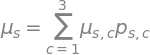

'----------------------------------'

'----------------------------------'

gamma,rho[A],rho[B],rho[P],stable
0.5,0.257143,0.2,0.2,True
0.55,0.282857,0.22,0.22,True
0.6,0.308571,0.24,0.24,True
0.65,0.334286,0.26,0.26,True
0.7,0.36,0.28,0.28,True
0.75,0.385714,0.3,0.3,True
0.8,0.411429,0.32,0.32,True
0.85,0.437143,0.34,0.34,True
0.9,0.462857,0.36,0.36,True
0.95,0.488571,0.38,0.38,True


'----------------------------------'

gamma,E[T][A],E[T][B],E[T][P],E[N][A],E[N][B],E[N][P],X[A],X[B],X[P]
0.5,0.230769,0.5,0.5,0.346154,0.25,0.25,1.5,0.5,0.5
0.55,0.239044,0.512821,0.512821,0.394422,0.282051,0.282051,1.65,0.55,0.55
0.6,0.247934,0.526316,0.526316,0.446281,0.315789,0.315789,1.8,0.6,0.6
0.65,0.257511,0.540541,0.540541,0.502146,0.351351,0.351351,1.95,0.65,0.65
0.7,0.267857,0.555556,0.555556,0.5625,0.388889,0.388889,2.1,0.7,0.7
0.75,0.27907,0.571429,0.571429,0.627907,0.428571,0.428571,2.25,0.75,0.75
0.8,0.291262,0.588235,0.588235,0.699029,0.470588,0.470588,2.4,0.8,0.8
0.85,0.304569,0.606061,0.606061,0.77665,0.515152,0.515152,2.55,0.85,0.85
0.9,0.319149,0.625,0.625,0.861702,0.5625,0.5625,2.7,0.9,0.9
0.95,0.335196,0.645161,0.645161,0.955307,0.612903,0.612903,2.85,0.95,0.95


'----------------------------------'

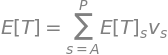

gamma,E[T][S],E[N][S],X[S]
0.5,1.69231,0.846154,0.5
0.55,1.74277,0.958525,0.55
0.6,1.79643,1.07786,0.6
0.65,1.85361,1.20485,0.65
0.7,1.91468,1.34028,0.7
0.75,1.98007,1.48505,0.75
0.8,2.05026,1.64021,0.8
0.85,2.12583,1.80695,0.85
0.9,2.20745,1.9867,0.9
0.95,2.29591,2.18111,0.95


In [32]:
improvments = [0.7, 0.6, 0.5, 0.4]
for i in improvments:
    service_rates_B_improved['B']['1'] = 1 / i
    service_rates = service_rates_B_improved
    external_arrival_rates = external_arrival_rates_heavy

    obj = f"obj4_{str(i).replace('.', '')}"

    mu_vals = calc_mu_vals()
    display(sep_line)
    rho_values, stable_rates = calc_rho_vals(obj)
    display(sep_line)
    e_t_values, e_n_values, x_values = calc_local_performances(obj)
    display(sep_line)
    e_t_global_values, e_n_global_values, x_global_values = calc_global_performances(obj)